In [2]:
import pandas as pd 
import torch
import random

es_df = pd.read_csv('CMDPS_dataset/ES/meta/ES_meta.csv')
es_df


torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)


In [3]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
import scipy.signal as signal
from mosqito.utils.time_segmentation import time_segmentation

import torch
import torch.nn.functional
import librosa

def get_tensor(filename):
    input_array, sr = librosa.load(filename, sr=12800, mono=True)

    nperseg = 2046 # fs = 12800Hz 기준 Δt = 0.16s(Δf = 6.25Hz)
    noverlap = 1536 # hop size(noverlap = TL time increment)

    P_ref = 20e-6


    sig, _ = time_segmentation(
            input_array, sr, nperseg=nperseg, noverlap=noverlap, is_ecma=False
        )
    # print(sig.shape)
    sig = torch.from_numpy(sig)


    nfft = sig.shape[0]
    nseg = sig.shape[1]
    window = np.hanning(nfft)
    window = np.tile(window,(nseg,1)).T
    # spec = 1 / np.mean(window[:,0]) * fft(sig * window, n=nfft, axis=0)/nperseg
    spec = fft(sig, n=nfft, axis=0)[0:nfft//2]
    spec_abs = 2*abs(spec)/nfft

    spec_abs = 20 * (np.log10(spec_abs*50000)) # 진동데이터는 50000 대신 10**6

    # print(spec_abs.shape)
    # print(spec_abs.max())

    stft_result = torch.from_numpy(spec_abs)

    # print(stft_result)    

    # 주파수 bins 계산
    freqs = np.linspace(0, 12800 / 2, stft_result.size(0))
        
    # A-weighting dB 값 계산
    a_weighting_db = librosa.A_weighting(freqs)
        
    # 텐서로 변환
    a_weighting_scale_tensor = torch.from_numpy(a_weighting_db)
    #     print(torch.abs(a_weighting_scale_tensor).log10().unsqueeze(1).shape)
        
    # A-weighted STFT 계산
    a_weighted_stft = stft_result + a_weighting_scale_tensor.unsqueeze(1)

    a_weighted_stft = a_weighted_stft.T
    a_weighted_stft = torch.where(a_weighted_stft < 0, 0, a_weighted_stft).float()

    # print(a_weighted_stft.shape) # bin 하나가 6.25. 양품에는 100~3200 Hz: 16~512   불량품에는 800~3200 Hz. 128~512

    return a_weighted_stft[:,16:513] # 

In [4]:
es_normal_list = []
es_abnormal_list = []

es_abnormal_name= []

for idx in es_df.index:
    row = es_df.loc[idx]
    filename = './CMDPS_dataset/ES/audio/' + row['filename']
    print(filename)
    if row['category'] == 'Normal':
        ten = get_tensor(filename)
        es_normal_list.append(ten.unsqueeze(0))
    else:
        ten = get_tensor(filename)
        es_abnormal_list.append(ten.unsqueeze(0))


./CMDPS_dataset/ES/audio/#01_SX2_Normal_ES_RH_1_3_Mic_30cm_S.wav


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/librosa/core/convert.py:1870: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


./CMDPS_dataset/ES/audio/#01_SX2_Normal_ES_RH_2_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#01_SX2_Normal_ES_LH_1_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#01_SX2_Normal_ES_LH_2_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#02_SX2_Normal_ES_LH_1_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#02_SX2_Normal_ES_RH_1_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#02_SX2_Normal_ES_LH_2_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#02_SX2_Normal_ES_RH_2_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#03_SX2_Normal_ES_LH_2_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#03_SX2_Normal_ES_LH_1_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#03_SX2_Normal_ES_RH_1_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#03_SX2_Normal_ES_RH_2_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#04_SX2_Normal_ES_RH_2_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#04_SX2_Normal_ES_LH_2_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#04_SX2_Normal_ES_LH_1_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/#04_SX2_Normal_ES_RH_1_3_Mic_30cm_S.wav
./CMDPS_dataset/ES/audio/

In [5]:
es_normal_list[0].shape

torch.Size([1, 98, 497])

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define the autoencoder model
class es_Autoencoder(nn.Module):
    def __init__(self):
        super(es_Autoencoder, self).__init__() # ([ 98, 497])
        # Encoder
        self.encoder = nn.Sequential( # Given groups=1, weight of size [16, 128, 3, 3], expected input[1, 32, 8, 95] to have 128 channels, but got 32 channels instead
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 16, 49, 249)
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 32, 25, 125)
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 64, 13, 63)
            nn.ReLU(True),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 32, 7, 32)
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 16, 4, 16)
            nn.ReLU(True),
            nn.Conv2d(16, 1, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 1, 2, 8)
            #nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output shape: (b, 16, 4, 16)  
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=(1,1), output_padding=(0, 1)),  # Output shape: (b, 32, 7, 32) 
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=(1,1), output_padding=(0,0)),  # Output shape: (b, 64, 13, 63) 
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),  # Output shape: (b, 32, 25, 125)  
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=(1,1), output_padding=(0,0)),  # Output shape: (b, 16, 49, 249)  
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=(1,1), output_padding=(1,0)),  # Output shape: (b, 1, 98, 497) 
            #nn.Tanh()
        )
# output padding must be smaller than stride
    def forward(self, x):
        mid = self.encoder(x)
        x = self.decoder(mid)
        return x
    
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


test_autoencoder = es_Autoencoder()

input_tensor = torch.randn(1, 1, 98, 497)  # (batch_size, channels, height, width)

# Forward pass through the autoencoder
output_tensor = test_autoencoder(input_tensor)

# Print the shapes of input and output tensors
print("Input Tensor Shape:", input_tensor.shape)
print("Output Tensor Shape:", output_tensor.shape)



Input Tensor Shape: torch.Size([1, 1, 98, 497])
Output Tensor Shape: torch.Size([1, 1, 98, 497])


In [7]:
from torchsummary import summary
summary(test_autoencoder, (1, 98, 497), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 49, 249]             160
              ReLU-2          [-1, 16, 49, 249]               0
            Conv2d-3          [-1, 32, 25, 125]           4,640
              ReLU-4          [-1, 32, 25, 125]               0
            Conv2d-5           [-1, 64, 13, 63]          18,496
              ReLU-6           [-1, 64, 13, 63]               0
            Conv2d-7            [-1, 32, 7, 32]          18,464
              ReLU-8            [-1, 32, 7, 32]               0
            Conv2d-9            [-1, 16, 4, 16]           4,624
             ReLU-10            [-1, 16, 4, 16]               0
           Conv2d-11              [-1, 1, 2, 8]             145
  ConvTranspose2d-12            [-1, 16, 4, 16]             160
             ReLU-13            [-1, 16, 4, 16]               0
  ConvTranspose2d-14            [-1, 32

In [8]:
def train(dataset_list, model):
    dev = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
    customdataset = CustomDataset(dataset_list)
    train_loader = DataLoader(customdataset, batch_size=32, shuffle=True)


    # Initialize the model, loss function, and optimizer
    autoencoder = model().to(dev)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    # Train the autoencoder
    num_epochs = 300
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader): # i-th batch
            inputs = data
            inputs = inputs.to(dev)

            optimizer.zero_grad()

            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'epoch : {epoch}, loss: {running_loss}')


    print('Finished Training')

    encoded_list = []
    with torch.no_grad():
        for i in dataset_list:
            encoded_list.append(autoencoder.encoder(i.to(dev)).flatten())

    return encoded_list
           


In [9]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)

encoded_es_normal_list = train(es_normal_list, es_Autoencoder)
encoded_es_abnormal_list = train(es_abnormal_list, es_Autoencoder)

epoch : 0, loss: 1580.5487670898438
epoch : 1, loss: 1343.2400817871094
epoch : 2, loss: 714.2973365783691
epoch : 3, loss: 479.99991607666016
epoch : 4, loss: 362.98207092285156
epoch : 5, loss: 331.3643093109131
epoch : 6, loss: 317.51524543762207
epoch : 7, loss: 310.86925315856934
epoch : 8, loss: 306.61149406433105
epoch : 9, loss: 303.3462257385254
epoch : 10, loss: 301.2961540222168
epoch : 11, loss: 299.0568027496338
epoch : 12, loss: 297.5716972351074
epoch : 13, loss: 296.52982330322266
epoch : 14, loss: 296.1680450439453
epoch : 15, loss: 294.81053161621094
epoch : 16, loss: 292.7344856262207
epoch : 17, loss: 293.15394020080566
epoch : 18, loss: 290.33859634399414
epoch : 19, loss: 289.96502685546875
epoch : 20, loss: 289.52135848999023
epoch : 21, loss: 288.2288570404053
epoch : 22, loss: 288.49863052368164
epoch : 23, loss: 288.22818756103516
epoch : 24, loss: 287.3766555786133
epoch : 25, loss: 288.2293243408203
epoch : 26, loss: 287.2251625061035
epoch : 27, loss: 286.6

In [10]:
print(len(encoded_es_normal_list))
print(len(encoded_es_abnormal_list))

298
235


In [11]:
from sklearn.cluster import KMeans

es_concated = encoded_es_normal_list + encoded_es_abnormal_list
es_concated = torch.stack(es_concated).cpu().numpy()

# Run k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0)
es_cluster_labels = kmeans.fit_predict(es_concated)




/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
es_normal_cnt={0:0, 1:0} # total should be: 298
es_abnormal_cnt={0:0, 1:0} # 243
for i, cl_label in enumerate(es_cluster_labels):
    if i < len(encoded_es_normal_list):
        es_normal_cnt[cl_label]+= 1
    else:
        es_abnormal_cnt[cl_label] += 1
    


In [13]:
print(es_normal_cnt)
print(es_abnormal_cnt)


{0: 298, 1: 0}
{0: 0, 1: 235}


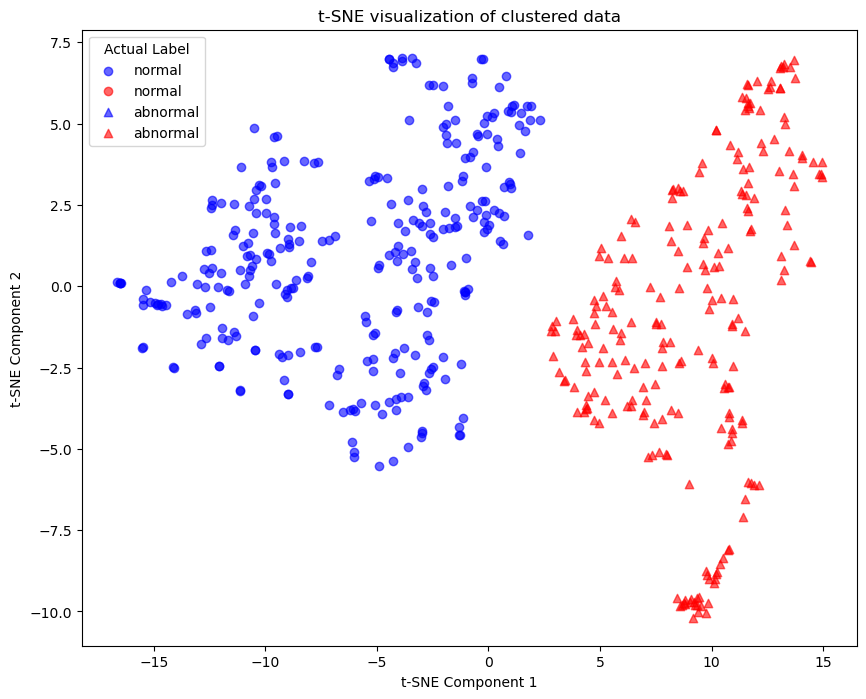

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_embedded = tsne.fit_transform(es_concated)

# Plotting
plt.figure(figsize=(10, 8))

markers = ['o', '^']  # Circle for class 0, triangle for class 1
colors = ['blue', 'red']

original_labels = [0]*len(encoded_es_normal_list) + [1]*len(encoded_es_abnormal_list)

y = [0]*len(encoded_es_normal_list) + [1]*len(encoded_es_abnormal_list)
label_map = {0:'normal', 1:'abnormal'}

for original_label in np.unique(original_labels):
    for cluster_label in np.unique(es_cluster_labels):
        indices = (np.array(original_labels) == original_label) & (np.array(es_cluster_labels) == cluster_label)
        plt.scatter(
            X_embedded[indices, 0], 
            X_embedded[indices, 1], 
            c=colors[cluster_label],  # Color by cluster label
            marker=markers[original_label],  # Marker by original label
            label=f'{label_map[original_label]}',
            alpha=0.6
        )
    

plt.legend(title='Actual Label')

# scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=es_cluster_labels, cmap='bwr', alpha=0)
# plt.colorbar(scatter, ticks=[0, 1], label='Cluster Label')  # Binary ticks for cluster labels

plt.title('t-SNE visualization of clustered data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [15]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)


es_grr_list = []
es_sg_list = []
es_dol_list = []


for idx in es_df.index:
    row = es_df.loc[idx]
    filename = './CMDPS_dataset/ES/audio/' + row['filename']
    if row['category'] == 'GRR':
        ten = get_tensor(filename)
        es_grr_list.append(ten.unsqueeze(0))

    elif row['category'] == 'SG':
        ten = get_tensor(filename)
        es_sg_list.append(ten.unsqueeze(0))

    elif row['category'] == 'DOL':
        ten = get_tensor(filename)
        es_dol_list.append(ten.unsqueeze(0))
    


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/librosa/core/convert.py:1870: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


In [16]:
encoded_es_grr_list = train(es_grr_list,es_Autoencoder)
encoded_es_dol_list = train(es_dol_list, es_Autoencoder)
encoded_es_sg_list = train(es_sg_list, es_Autoencoder)

epoch : 0, loss: 212.37095642089844
epoch : 1, loss: 212.24752807617188
epoch : 2, loss: 212.12399291992188
epoch : 3, loss: 211.9994659423828
epoch : 4, loss: 211.87086486816406
epoch : 5, loss: 211.73484802246094
epoch : 6, loss: 211.58657836914062
epoch : 7, loss: 211.41567993164062
epoch : 8, loss: 211.19741821289062
epoch : 9, loss: 210.88645935058594
epoch : 10, loss: 210.388671875
epoch : 11, loss: 209.4820556640625
epoch : 12, loss: 207.72323608398438
epoch : 13, loss: 204.28521728515625
epoch : 14, loss: 197.7318572998047
epoch : 15, loss: 185.73512268066406
epoch : 16, loss: 165.18629455566406
epoch : 17, loss: 134.85035705566406
epoch : 18, loss: 110.19566345214844
epoch : 19, loss: 152.32992553710938
epoch : 20, loss: 117.16194152832031
epoch : 21, loss: 94.99520111083984
epoch : 22, loss: 95.71453094482422
epoch : 23, loss: 100.71570587158203
epoch : 24, loss: 101.49797821044922
epoch : 25, loss: 96.33460998535156
epoch : 26, loss: 85.93677520751953
epoch : 27, loss: 73.69

In [17]:
from sklearn.cluster import KMeans

rps_concated = encoded_es_grr_list +  encoded_es_sg_list +  encoded_es_dol_list
rps_concated = torch.stack(rps_concated).cpu().numpy()

# Run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
rps_cluster_labels = kmeans.fit_predict(rps_concated)




es_clstr_grr_cnt={0:0, 1:0, 2:0} 
es_clstr_sg_cnt={0:0, 1:0, 2:0} 
es_clstr_dol_cnt={0:0, 1:0, 2:0} 

for i, cl_label in enumerate(rps_cluster_labels):
    if i < len(encoded_es_grr_list):
        es_clstr_grr_cnt[cl_label]+= 1
    elif i < len(encoded_es_grr_list) + len(encoded_es_sg_list):
        es_clstr_sg_cnt[cl_label]+= 1
    else:
        es_clstr_dol_cnt[cl_label]+= 1

      
print(es_clstr_grr_cnt)
print(es_clstr_sg_cnt)
print(es_clstr_dol_cnt) 



{0: 0, 1: 30, 2: 0}
{0: 0, 1: 98, 2: 0}
{0: 53, 1: 0, 2: 54}


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
es_clstr_grrdol_cnt={0:0, 1:0} 
es_clstr_ssg_cnt={0:0, 1:0} 

_2kmeans = KMeans(n_clusters=2, random_state=0)
_2es_cluster_labels = _2kmeans.fit_predict(rps_concated)

for i, cl_label in enumerate(_2es_cluster_labels):
    if i < len(encoded_es_grr_list):
        es_clstr_grrdol_cnt[cl_label]+= 1
    elif i < len(encoded_es_grr_list) + len(encoded_es_sg_list) :
        es_clstr_ssg_cnt[cl_label] += 1
    else:
        es_clstr_grrdol_cnt[cl_label] +=1

print(es_clstr_grrdol_cnt) #grrdol | sg
print(es_clstr_ssg_cnt)


{0: 107, 1: 30}
{0: 0, 1: 98}


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [19]:
es_clstr_grr_cnt={0:0, 1:0} 
es_clstr_dol_cnt={0:0, 1:0} 

es_grrdol_concated = encoded_es_grr_list + encoded_es_dol_list
es_grrdol_concated = torch.stack(es_grrdol_concated).cpu().numpy()

_2es_cluster_labels = _2kmeans.fit_predict(es_grrdol_concated)

for i, cl_label in enumerate(_2es_cluster_labels):
    if i < len(encoded_es_grr_list):
        es_clstr_grr_cnt[cl_label]+= 1
    else:
        es_clstr_dol_cnt[cl_label] +=1

print(es_clstr_grr_cnt)
print(es_clstr_dol_cnt) 


{0: 0, 1: 30}
{0: 107, 1: 0}


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:
rps_df = pd.read_csv('CMDPS_dataset/1.0RPS/meta/1.0RPS_meta.csv')

In [21]:
rps_normal_list = []
rps_abnormal_list = [] 

rps_abnormal_name= []

for idx in rps_df.index:
    row = rps_df.loc[idx]
    filename = './CMDPS_dataset/1.0RPS/audio/' + row['filename']
    if row['category'] == 'Normal':
        ten = get_tensor(filename)
        rps_normal_list.append(ten.unsqueeze(0))
    else:
        ten = get_tensor(filename)
        rps_abnormal_list.append(ten.unsqueeze(0))


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/librosa/core/convert.py:1870: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


In [22]:
rps_normal_list[1].shape

torch.Size([1, 108, 497])

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define the autoencoder model
class rps_Autoencoder(nn.Module):
    def __init__(self):
        super(rps_Autoencoder, self).__init__() # ([ 108, 497])
        # Encoder
        self.encoder = nn.Sequential( # Given groups=1, weight of size [16, 128, 3, 3], expected input[1, 32, 8, 95] to have 128 channels, but got 32 channels instead
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 16, 54, 249)
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 32, 27, 125)
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 64, 14, 63)
            nn.ReLU(True),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 32, 7, 32)
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 16, 4, 16)
            nn.ReLU(True),
            nn.Conv2d(16, 1, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 1, 2, 8)
            #nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output shape: (b, 16, 4, 16)  
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=(1,1), output_padding=(0, 1)),  # Output shape: (b, 32, 7, 32) 
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=(1,1), output_padding=(1,0)),  # Output shape: (b, 64, 14, 63) 
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),  # Output shape: (b, 32, 27, 125)  
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=(1,1), output_padding=(1,0)),  # Output shape: (b, 16, 49, 249)  
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=(1,1), output_padding=(1,0)),  # Output shape: (b, 1, 98, 497) 
            #nn.Tanh()
        )
# output padding must be smaller than stride
    def forward(self, x):
        mid = self.encoder(x)
        x = self.decoder(mid)
        return x
    
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


test_autoencoder = rps_Autoencoder()

input_tensor = torch.randn(1, 1, 108, 497)  # (batch_size, channels, height, width)

# Forward pass through the autoencoder
output_tensor = test_autoencoder(input_tensor)

# Print the shapes of input and output tensors
print("Input Tensor Shape:", input_tensor.shape)
print("Output Tensor Shape:", output_tensor.shape)



Input Tensor Shape: torch.Size([1, 1, 108, 497])
Output Tensor Shape: torch.Size([1, 1, 108, 497])


In [24]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)


encoded_rps_normal_list = train(rps_normal_list,rps_Autoencoder)
encoded_rps_abnormal_list = train(rps_abnormal_list, rps_Autoencoder)

epoch : 0, loss: 626.4953460693359
epoch : 1, loss: 623.9672546386719
epoch : 2, loss: 609.0784530639648
epoch : 3, loss: 457.3465881347656
epoch : 4, loss: 330.8879699707031
epoch : 5, loss: 270.8651809692383
epoch : 6, loss: 232.65091705322266
epoch : 7, loss: 202.07265090942383
epoch : 8, loss: 178.92626190185547
epoch : 9, loss: 166.90249633789062
epoch : 10, loss: 160.0663661956787
epoch : 11, loss: 154.665922164917
epoch : 12, loss: 150.6093235015869
epoch : 13, loss: 148.0120735168457
epoch : 14, loss: 146.27656364440918
epoch : 15, loss: 144.44835662841797
epoch : 16, loss: 143.22735214233398
epoch : 17, loss: 142.18978881835938
epoch : 18, loss: 141.35026359558105
epoch : 19, loss: 141.02141761779785
epoch : 20, loss: 140.48571014404297
epoch : 21, loss: 140.23078727722168
epoch : 22, loss: 139.54595947265625
epoch : 23, loss: 139.2688503265381
epoch : 24, loss: 138.6765651702881
epoch : 25, loss: 138.2486114501953
epoch : 26, loss: 138.1433391571045
epoch : 27, loss: 137.5780

In [25]:
rps_concated = encoded_rps_normal_list + encoded_rps_abnormal_list
rps_concated = torch.stack(rps_concated).cpu().numpy()

# Run k-means clustering
rps_cluster_labels = _2kmeans.fit_predict(rps_concated)

rps_normal_cnt={0:0, 1:0} # total should be: 145
rps_abnormal_cnt={0:0, 1:0} # 102

for i, cl_label in enumerate(rps_cluster_labels):
    if i < len(encoded_rps_normal_list):
        rps_normal_cnt[cl_label]+= 1
    else:
        rps_abnormal_cnt[cl_label] += 1
    
print(rps_normal_cnt)
print(rps_abnormal_cnt)


{0: 143, 1: 2}
{0: 33, 1: 67}


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


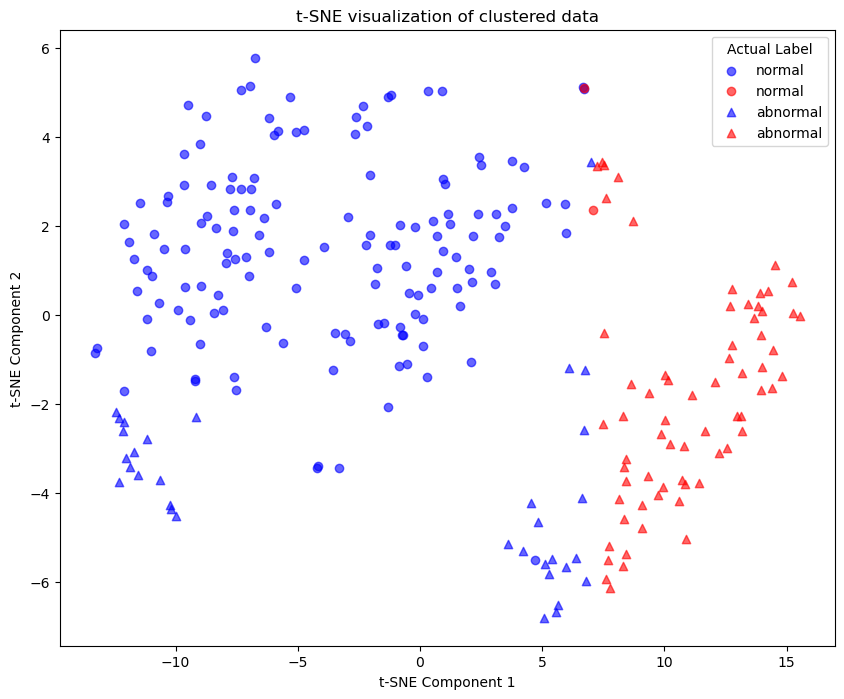

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_embedded = tsne.fit_transform(rps_concated)

# Plotting
plt.figure(figsize=(10, 8))

markers = ['o', '^']  # Circle for class 0, triangle for class 1
colors = ['blue', 'red']

original_labels = [0]*len(encoded_rps_normal_list) + [1]*len(encoded_rps_abnormal_list)

y = [0]*len(encoded_rps_normal_list) + [1]*len(encoded_rps_abnormal_list)
label_map = {0:'normal', 1:'abnormal'}

for original_label in np.unique(original_labels):
    for cluster_label in np.unique(rps_cluster_labels):
        indicrps = (np.array(original_labels) == original_label) & (np.array(rps_cluster_labels) == cluster_label)
        plt.scatter(
            X_embedded[indicrps, 0], 
            X_embedded[indicrps, 1], 
            c=colors[cluster_label],  # Color by cluster label
            marker=markers[original_label],  # Marker by original label
            label=f'{label_map[original_label]}',
            alpha=0.6
        )
    

plt.legend(title='Actual Label')

# scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=rps_cluster_labels, cmap='bwr', alpha=0)
# plt.colorbar(scatter, ticks=[0, 1], label='Cluster Label')  # Binary ticks for cluster labels

plt.title('t-SNE visualization of clustered data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [27]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)


rps_grr_list = []
rps_sg_list = []
rps_dol_list = []


for idx in rps_df.index:
    row = rps_df.loc[idx]
    filename = './CMDPS_dataset/1.0RPS/audio/' + row['filename']
    if row['category'] == 'GRR':
        ten = get_tensor(filename)
        rps_grr_list.append(ten.unsqueeze(0))

    elif row['category'] == 'SG':
        ten = get_tensor(filename)
        rps_sg_list.append(ten.unsqueeze(0))

    elif row['category'] == 'DOL':
        ten = get_tensor(filename)
        rps_dol_list.append(ten.unsqueeze(0))
    


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/librosa/core/convert.py:1870: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


In [28]:
encoded_rps_grr_list = train(rps_grr_list,rps_Autoencoder)
encoded_rps_dol_list = train(rps_dol_list, rps_Autoencoder)
encoded_rps_sg_list = train(rps_sg_list, rps_Autoencoder)

epoch : 0, loss: 185.728759765625
epoch : 1, loss: 185.61138916015625
epoch : 2, loss: 185.4939422607422
epoch : 3, loss: 185.3756103515625
epoch : 4, loss: 185.25355529785156
epoch : 5, loss: 185.12469482421875
epoch : 6, loss: 184.98472595214844
epoch : 7, loss: 184.8242645263672
epoch : 8, loss: 184.62078857421875
epoch : 9, loss: 184.33660888671875
epoch : 10, loss: 183.8929901123047
epoch : 11, loss: 183.10659790039062
epoch : 12, loss: 181.62123107910156
epoch : 13, loss: 178.76177978515625
epoch : 14, loss: 173.36093139648438
epoch : 15, loss: 163.51400756835938
epoch : 16, loss: 146.6734161376953
epoch : 17, loss: 121.54698181152344
epoch : 18, loss: 98.8312759399414
epoch : 19, loss: 131.84979248046875
epoch : 20, loss: 105.82266998291016
epoch : 21, loss: 86.16229248046875
epoch : 22, loss: 85.4823989868164
epoch : 23, loss: 89.20740509033203
epoch : 24, loss: 89.74688720703125
epoch : 25, loss: 85.41765594482422
epoch : 26, loss: 76.84500885009766
epoch : 27, loss: 67.025650

In [29]:
from sklearn.cluster import KMeans

rps_concated = encoded_rps_grr_list +  encoded_rps_sg_list +  encoded_rps_dol_list
rps_concated = torch.stack(rps_concated).cpu().numpy()

# Run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
rps_cluster_labels = kmeans.fit_predict(rps_concated)




rps_clstr_grr_cnt={0:0, 1:0, 2:0} 
rps_clstr_sg_cnt={0:0, 1:0, 2:0} 
rps_clstr_dol_cnt={0:0, 1:0, 2:0} 

for i, cl_label in enumerate(rps_cluster_labels):
    if i < len(encoded_rps_grr_list):
        rps_clstr_grr_cnt[cl_label]+= 1
    elif i < len(encoded_rps_grr_list) + len(encoded_rps_sg_list):
        rps_clstr_sg_cnt[cl_label]+= 1
    else:
        rps_clstr_dol_cnt[cl_label]+= 1

      
print(rps_clstr_grr_cnt)
print(rps_clstr_sg_cnt)
print(rps_clstr_dol_cnt) 



{0: 11, 1: 0, 2: 2}
{0: 41, 1: 0, 2: 3}
{0: 2, 1: 18, 2: 23}


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [30]:
rps_clstr_grrdol_cnt={0:0, 1:0} 
rps_clstr_ssg_cnt={0:0, 1:0} 

_2kmeans = KMeans(n_clusters=2, random_state=0)
_2rps_cluster_labels = _2kmeans.fit_predict(rps_concated)

for i, cl_label in enumerate(_2rps_cluster_labels):
    if i < len(encoded_rps_grr_list):
        rps_clstr_grrdol_cnt[cl_label]+= 1
    elif i < len(encoded_rps_grr_list) + len(encoded_rps_sg_list) :
        rps_clstr_ssg_cnt[cl_label] += 1
    else:
        rps_clstr_grrdol_cnt[cl_label] +=1

print(rps_clstr_grrdol_cnt) #grrdol | sg
print(rps_clstr_ssg_cnt)


{0: 22, 1: 34}
{0: 44, 1: 0}


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:
from sklearn.cluster import KMeans
rps_clstr_grr_cnt={0:0, 1:0} 
rps_clstr_dol_cnt={0:0, 1:0} 

rps_grrdol_concated = encoded_rps_grr_list + encoded_rps_dol_list
rps_grrdol_concated = torch.stack(rps_grrdol_concated).cpu().numpy()

_2kmeans = KMeans(n_clusters=2, random_state=0)
_2rps_cluster_labels = _2kmeans.fit_predict(rps_grrdol_concated)

for i, cl_label in enumerate(_2rps_cluster_labels):
    if i < len(encoded_rps_grr_list):
        rps_clstr_grr_cnt[cl_label]+= 1
    else:
        rps_clstr_dol_cnt[cl_label] +=1

print(rps_clstr_grr_cnt)
print(rps_clstr_dol_cnt) 


{0: 0, 1: 13}
{0: 34, 1: 9}


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [32]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
import scipy.signal as signal
from mosqito.utils.time_segmentation import time_segmentation

import torch
import torch.nn.functional
import librosa

def line_get_tensor(filename):
    input_array, sr = librosa.load(filename, sr=12800, mono=True)

    nperseg = 2046 # fs = 12800Hz 기준 Δt = 0.16s(Δf = 6.25Hz)
    noverlap = 1536 # hop size(noverlap = TL time increment)

    P_ref = 20e-6


    sig, _ = time_segmentation(
            input_array, sr, nperseg=nperseg, noverlap=noverlap, is_ecma=False
        )
    # print(sig.shape)
    sig = torch.from_numpy(sig)


    nfft = sig.shape[0]
    nseg = sig.shape[1]
    window = np.hanning(nfft)
    window = np.tile(window,(nseg,1)).T
    # spec = 1 / np.mean(window[:,0]) * fft(sig * window, n=nfft, axis=0)/nperseg
    spec = fft(sig, n=nfft, axis=0)[0:nfft//2]
    spec_abs = 2*abs(spec)/nfft

    spec_abs = 20 * (np.log10(spec_abs*1e+6)) # 진동데이터는 50000 대신 10**6

    # print(spec_abs.shape)
    # print(spec_abs.max())

    stft_result = torch.from_numpy(spec_abs)

    # print(stft_result)    

    # 주파수 bins 계산
    a_weighted_stft = stft_result.T
    a_weighted_stft = torch.where(a_weighted_stft < 0, 0, a_weighted_stft).float()

    #print(a_weighted_stft.shape) # bin 하나가 6.25. 양품에는 100~3200 Hz: 16~512   불량품에는 800~3200 Hz. 128~512

    return a_weighted_stft[:,16:513] # 

In [33]:
line4_df = pd.read_csv('CMDPS_dataset/LINE_4/meta/LINE4_meta.csv')

line4_normal_list = []
line4_abnormal_list = []

for idx in line4_df.index:
    row = line4_df.loc[idx]
    filename = './CMDPS_dataset/LINE_4/audio/' + row['filename']
    if row['category'] == 'Normal':
        ten = line_get_tensor(filename)
        line4_normal_list.append(ten.unsqueeze(0))
    else:
        ten = line_get_tensor(filename)
        line4_abnormal_list.append(ten.unsqueeze(0))

In [34]:
line7_df = pd.read_csv('CMDPS_dataset/LINE_7/meta/LINE7_meta.csv')

line7_normal_list = []
line7_abnormal_list = []

for idx in line7_df.index:
    row = line7_df.loc[idx]
    filename = './CMDPS_dataset/LINE_7/audio/' + row['filename']
    if row['category'] == 'Normal':
        ten = line_get_tensor(filename)
        line7_normal_list.append(ten.unsqueeze(0))
    else:
        ten = line_get_tensor(filename)
        line7_abnormal_list.append(ten.unsqueeze(0))

In [35]:
print(line4_abnormal_list[0].shape)
print(line7_abnormal_list[0].shape)

torch.Size([1, 24, 497])
torch.Size([1, 24, 497])


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define the autoencoder model
class line_Autoencoder(nn.Module):
    def __init__(self):
        super(line_Autoencoder, self).__init__() # ([ 24, 497])
        # Encoder
        self.encoder = nn.Sequential( # Given groups=1, weight of size [16, 128, 3, 3], expected input[1, 32, 8, 95] to have 128 channels, but got 32 channels instead
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 16, 12, 249)
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 32, 6, 125)
            nn.ReLU(True),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),  # Output shape: (b, 64, 3, 63)
            nn.ReLU(True),
            nn.Conv2d(16, 1, kernel_size=3, stride=2, padding=1)  # Output shape: (b, 32, 2, 32)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 16, kernel_size=3, stride=2, padding=1, output_padding=0),  # Output shape: (b, 16, 3, 63)  
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=(1,1), output_padding=(1, 0)),  # Output shape: (b, 32, 6, 125) 
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=(1,1), output_padding=(1,0)),  # Output shape: (b, 64, 12, 249) 
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=(1,0)),  # Output shape: (b, 32, 24, 497)  
            
        )
# output padding must be smaller than stride
    def forward(self, x):
        mid = self.encoder(x)
        x = self.decoder(mid)
        return x
    
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


test_autoencoder = line_Autoencoder()

input_tensor = torch.randn(1, 1, 24, 497)  # (batch_size, channels, height, width)

# Forward pass through the autoencoder
output_tensor = test_autoencoder(input_tensor)

# Print the shapes of input and output tensors
print("Input Tensor Shape:", input_tensor.shape)
print("Output Tensor Shape:", output_tensor.shape)



Input Tensor Shape: torch.Size([1, 1, 24, 497])
Output Tensor Shape: torch.Size([1, 1, 24, 497])


In [37]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)

encoded_line4_normal_list = train(line4_normal_list, line_Autoencoder)
encoded_line4_abnormal_list = train(line4_abnormal_list, line_Autoencoder)

epoch : 0, loss: 61718.3095703125
epoch : 1, loss: 60798.05615234375
epoch : 2, loss: 45925.7099609375
epoch : 3, loss: 21080.689086914062
epoch : 4, loss: 10722.135131835938
epoch : 5, loss: 6014.541534423828
epoch : 6, loss: 4141.358947753906
epoch : 7, loss: 3018.4127502441406
epoch : 8, loss: 2289.0418701171875
epoch : 9, loss: 1829.503646850586
epoch : 10, loss: 1524.5530853271484
epoch : 11, loss: 1297.6140823364258
epoch : 12, loss: 1127.9720458984375
epoch : 13, loss: 996.4055252075195
epoch : 14, loss: 892.2199478149414
epoch : 15, loss: 806.3395156860352
epoch : 16, loss: 734.7062072753906
epoch : 17, loss: 672.9985198974609
epoch : 18, loss: 617.5786743164062
epoch : 19, loss: 570.5165367126465
epoch : 20, loss: 530.1219673156738
epoch : 21, loss: 497.3155975341797
epoch : 22, loss: 471.2166557312012
epoch : 23, loss: 451.0901298522949
epoch : 24, loss: 436.091365814209
epoch : 25, loss: 425.33777236938477
epoch : 26, loss: 418.4156951904297
epoch : 27, loss: 413.32170486450

In [39]:
line4_concated = encoded_line4_normal_list + encoded_line4_abnormal_list 
line4_concated = torch.stack(line4_concated).cpu().numpy()

# Run k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0)
line4_cluster_labels = kmeans.fit_predict(line4_concated)

line4_normal_cnt={0:0, 1:0} # total should be: 243
line4_abnormal_cnt={0:0, 1:0} # 204


for i, cl_label in enumerate(line4_cluster_labels):
    if i < len(encoded_line4_normal_list):
        line4_normal_cnt[cl_label]+= 1
    else:
        line4_abnormal_cnt[cl_label] += 1
    
print(line4_normal_cnt)
print(line4_abnormal_cnt)


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0: 314, 1: 0}
{0: 0, 1: 226}


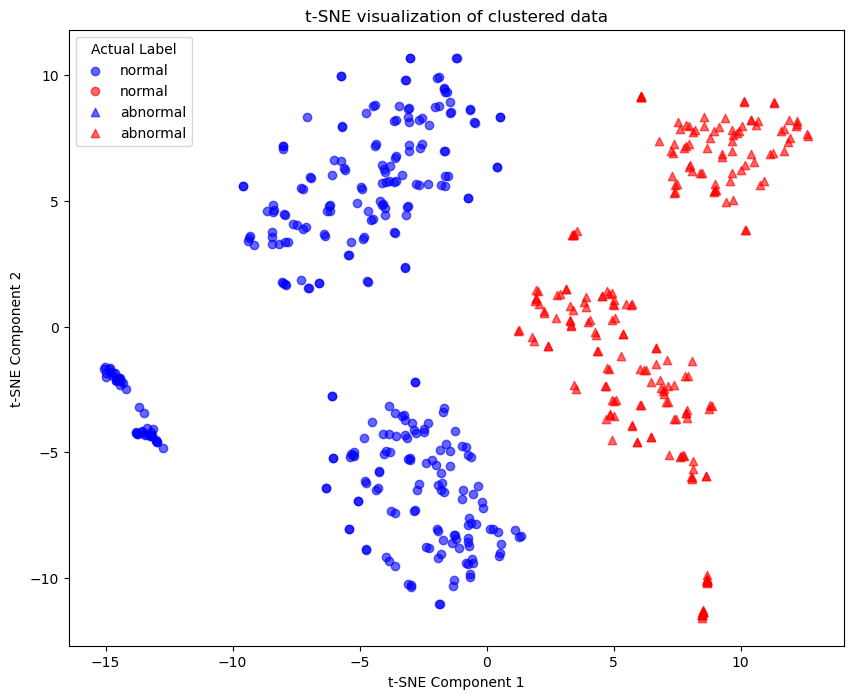

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_embedded = tsne.fit_transform(line4_concated)

# Plotting
plt.figure(figsize=(10, 8))

markers = ['o', '^']  # Circle for class 0, triangle for class 1
colors = ['blue', 'red']

original_labels = [0]*len(encoded_line4_normal_list) + [1]*len(encoded_line4_abnormal_list)

y = [0]*len(encoded_line4_normal_list) + [1]*len(encoded_line4_abnormal_list)
label_map = {0:'normal', 1:'abnormal'}

for original_label in np.unique(original_labels):
    for cluster_label in np.unique(line4_cluster_labels):
        indicline4 = (np.array(original_labels) == original_label) & (np.array(line4_cluster_labels) == cluster_label)
        plt.scatter(
            X_embedded[indicline4, 0], 
            X_embedded[indicline4, 1], 
            c=colors[cluster_label],  # Color by cluster label
            marker=markers[original_label],  # Marker by original label
            label=f'{label_map[original_label]}',
            alpha=0.6
        )
    

plt.legend(title='Actual Label')

# scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=line4_cluster_labels, cmap='bwr', alpha=0)
# plt.colorbar(scatter, ticks=[0, 1], label='Cluster Label')  # Binary ticks for cluster labels

plt.title('t-SNE visualization of clustered data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [41]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)


encoded_line7_normal_list = train(line7_normal_list, line_Autoencoder)
encoded_line7_abnormal_list = train(line7_abnormal_list, line_Autoencoder)

epoch : 0, loss: 59104.01513671875
epoch : 1, loss: 58258.1962890625
epoch : 2, loss: 44391.53515625
epoch : 3, loss: 20392.133422851562
epoch : 4, loss: 10272.176513671875
epoch : 5, loss: 5696.218994140625
epoch : 6, loss: 3872.866912841797
epoch : 7, loss: 2789.7003631591797
epoch : 8, loss: 2095.8762969970703
epoch : 9, loss: 1667.9261016845703
epoch : 10, loss: 1381.1746215820312
epoch : 11, loss: 1169.285140991211
epoch : 12, loss: 1010.8442611694336
epoch : 13, loss: 887.2648239135742
epoch : 14, loss: 790.8579330444336
epoch : 15, loss: 714.3870468139648
epoch : 16, loss: 652.6052513122559
epoch : 17, loss: 602.4627304077148
epoch : 18, loss: 561.8008766174316
epoch : 19, loss: 530.3648262023926
epoch : 20, loss: 506.29801177978516
epoch : 21, loss: 488.9921875
epoch : 22, loss: 476.53175354003906
epoch : 23, loss: 466.3805923461914
epoch : 24, loss: 458.1635437011719
epoch : 25, loss: 451.9397277832031
epoch : 26, loss: 447.9730529785156
epoch : 27, loss: 442.5220184326172
epo

In [42]:
line7_concated = encoded_line7_normal_list + encoded_line7_abnormal_list 
line7_concated = torch.stack(line7_concated).cpu().numpy()

# Run k-means clustering
line7_cluster_labels = _2kmeans.fit_predict(line7_concated)

line7_normal_cnt={0:0, 1:0} # total should be: 243
line7_abnormal_cnt={0:0, 1:0} # 204


for i, cl_label in enumerate(line7_cluster_labels):
    if i < len(encoded_line7_normal_list):
        line7_normal_cnt[cl_label]+= 1
    else:
        line7_abnormal_cnt[cl_label] += 1
    
print(line7_normal_cnt)
print(line7_abnormal_cnt)


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0: 314, 1: 0}
{0: 0, 1: 226}


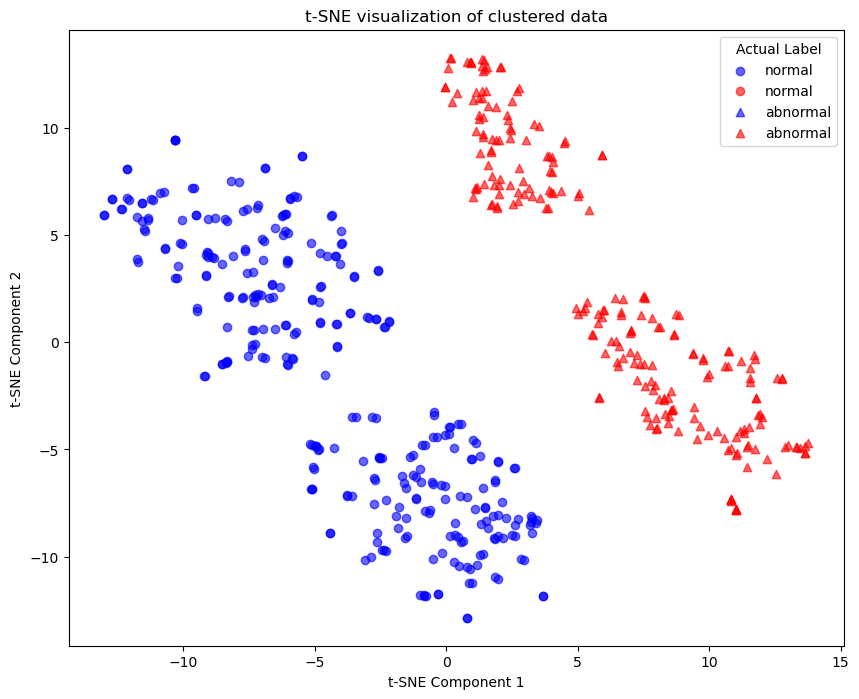

In [43]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=72)
X_embedded = tsne.fit_transform(line7_concated)

# Plotting
plt.figure(figsize=(10, 8))

markers = ['o', '^']  # Circle for class 0, triangle for class 1
colors = ['blue', 'red']

original_labels = [0]*len(encoded_line7_normal_list) + [1]*len(encoded_line7_abnormal_list)

y = [0]*len(encoded_line7_normal_list) + [1]*len(encoded_line7_abnormal_list)
label_map = {0:'normal', 1:'abnormal'}

for original_label in np.unique(original_labels):
    for cluster_label in np.unique(line7_cluster_labels):
        indicline7 = (np.array(original_labels) == original_label) & (np.array(line7_cluster_labels) == cluster_label)
        plt.scatter(
            X_embedded[indicline7, 0], 
            X_embedded[indicline7, 1], 
            c=colors[cluster_label],  # Color by cluster label
            marker=markers[original_label],  # Marker by original label
            label=f'{label_map[original_label]}',
            alpha=0.6
        )
    

plt.legend(title='Actual Label')

# scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=line7_cluster_labels, cmap='bwr', alpha=0)
# plt.colorbar(scatter, ticks=[0, 1], label='Cluster Label')  # Binary ticks for cluster labels

plt.title('t-SNE visualization of clustered data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [44]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)

line4_grr_list = []
line4_sg_list = []
line4_dol_list = []


for idx in line4_df.index:
    row = line4_df.loc[idx]
    filename = './CMDPS_dataset/LINE_4/audio/' + row['filename']
    if row['category'] == 'GRR':
        ten = line_get_tensor(filename)
        line4_grr_list.append(ten.unsqueeze(0))

    elif row['category'] == 'SG':
        ten = line_get_tensor(filename)
        line4_sg_list.append(ten.unsqueeze(0))

    elif row['category'] == 'DOL':
        ten = line_get_tensor(filename)
        line4_dol_list.append(ten.unsqueeze(0))
    

encoded_line4_grr_list = train(line4_grr_list,line_Autoencoder)
encoded_line4_dol_list = train(line4_dol_list, line_Autoencoder)
encoded_line4_sg_list = train(line4_sg_list, line_Autoencoder)
from sklearn.cluster import KMeans

line4_concated = encoded_line4_grr_list +  encoded_line4_sg_list +  encoded_line4_dol_list
line4_concated = torch.stack(line4_concated).cpu().numpy()

# Run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
line4_cluster_labels = kmeans.fit_predict(line4_concated)




line4_clstr_grr_cnt={0:0, 1:0, 2:0} 
line4_clstr_sg_cnt={0:0, 1:0, 2:0} 
line4_clstr_dol_cnt={0:0, 1:0, 2:0} 

for i, cl_label in enumerate(line4_cluster_labels):
    if i < len(encoded_line4_grr_list):
        line4_clstr_grr_cnt[cl_label]+= 1
    elif i < len(encoded_line4_grr_list) + len(encoded_line4_sg_list):
        line4_clstr_sg_cnt[cl_label]+= 1
    else:
        line4_clstr_dol_cnt[cl_label]+= 1

      
print(line4_clstr_grr_cnt)
print(line4_clstr_sg_cnt)
print(line4_clstr_dol_cnt) 


line4_clstr_grrdol_cnt={0:0, 1:0} 
line4_clstr_ssg_cnt={0:0, 1:0} 

_2kmeans = KMeans(n_clusters=2, random_state=0)
_2line4_cluster_labels = _2kmeans.fit_predict(line4_concated)

for i, cl_label in enumerate(_2line4_cluster_labels):
    if i < len(encoded_line4_grr_list):
        line4_clstr_grrdol_cnt[cl_label]+= 1
    elif i < len(encoded_line4_grr_list) + len(encoded_line4_sg_list) :
        line4_clstr_ssg_cnt[cl_label] += 1
    else:
        line4_clstr_grrdol_cnt[cl_label] +=1

print(line4_clstr_grrdol_cnt) #grrdol | sg
print(line4_clstr_ssg_cnt)

from sklearn.cluster import KMeans
line4_clstr_grr_cnt={0:0, 1:0} 
line4_clstr_dol_cnt={0:0, 1:0} 

line4_grrdol_concated = encoded_line4_grr_list + encoded_line4_dol_list
line4_grrdol_concated = torch.stack(line4_grrdol_concated).cpu().numpy()

_2kmeans = KMeans(n_clusters=2, random_state=0)
_2line4_cluster_labels = _2kmeans.fit_predict(line4_grrdol_concated)

for i, cl_label in enumerate(_2line4_cluster_labels):
    if i < len(encoded_line4_grr_list):
        line4_clstr_grr_cnt[cl_label]+= 1
    else:
        line4_clstr_dol_cnt[cl_label] +=1

print(line4_clstr_grr_cnt)
print(line4_clstr_dol_cnt) 



epoch : 0, loss: 5765.8701171875
epoch : 1, loss: 5765.474609375
epoch : 2, loss: 5765.07958984375
epoch : 3, loss: 5764.6552734375
epoch : 4, loss: 5764.17041015625
epoch : 5, loss: 5763.578125
epoch : 6, loss: 5762.810546875
epoch : 7, loss: 5761.75
epoch : 8, loss: 5760.25634765625
epoch : 9, loss: 5758.10302734375
epoch : 10, loss: 5754.98779296875
epoch : 11, loss: 5750.45751953125
epoch : 12, loss: 5743.9462890625
epoch : 13, loss: 5734.724609375
epoch : 14, loss: 5721.7138671875
epoch : 15, loss: 5703.4248046875
epoch : 16, loss: 5678.00341796875
epoch : 17, loss: 5642.89013671875
epoch : 18, loss: 5594.67041015625
epoch : 19, loss: 5529.05029296875
epoch : 20, loss: 5440.5751953125
epoch : 21, loss: 5322.5341796875
epoch : 22, loss: 5166.34228515625
epoch : 23, loss: 4962.69384765625
epoch : 24, loss: 4701.73095703125
epoch : 25, loss: 4375.787109375
epoch : 26, loss: 3982.83544921875
epoch : 27, loss: 3536.40478515625
epoch : 28, loss: 3077.7451171875
epoch : 29, loss: 2695.74

/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0: 0, 1: 0, 2: 14}
{0: 0, 1: 108, 2: 0}
{0: 104, 1: 0, 2: 0}


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0: 104, 1: 14}
{0: 0, 1: 108}
{0: 0, 1: 14}
{0: 104, 1: 0}


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [45]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)


line7_grr_list = []
line7_sg_list = []
line7_dol_list = []

for idx in line7_df.index:
    row = line7_df.loc[idx]
    filename = './CMDPS_dataset/LINE_7/audio/' + row['filename']
    if row['category'] == 'GRR':
        ten = line_get_tensor(filename)
        line7_grr_list.append(ten.unsqueeze(0))

    elif row['category'] == 'SG':
        ten = line_get_tensor(filename)
        line7_sg_list.append(ten.unsqueeze(0))

    elif row['category'] == 'DOL':
        ten = line_get_tensor(filename)
        line7_dol_list.append(ten.unsqueeze(0))
    

encoded_line7_grr_list = train(line7_grr_list,line_Autoencoder)
encoded_line7_dol_list = train(line7_dol_list, line_Autoencoder)
encoded_line7_sg_list = train(line7_sg_list, line_Autoencoder)
from sklearn.cluster import KMeans

line7_concated = encoded_line7_grr_list +  encoded_line7_sg_list +  encoded_line7_dol_list
line7_concated = torch.stack(line7_concated).cpu().numpy()

# Run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
line7_cluster_labels = kmeans.fit_predict(line7_concated)




line7_clstr_grr_cnt={0:0, 1:0, 2:0} 
line7_clstr_sg_cnt={0:0, 1:0, 2:0} 
line7_clstr_dol_cnt={0:0, 1:0, 2:0} 

for i, cl_label in enumerate(line7_cluster_labels):
    if i < len(encoded_line7_grr_list):
        line7_clstr_grr_cnt[cl_label]+= 1
    elif i < len(encoded_line7_grr_list) + len(encoded_line7_sg_list):
        line7_clstr_sg_cnt[cl_label]+= 1
    else:
        line7_clstr_dol_cnt[cl_label]+= 1

      
print(line7_clstr_grr_cnt)
print(line7_clstr_sg_cnt)
print(line7_clstr_dol_cnt) 


line7_clstr_grrdol_cnt={0:0, 1:0} 
line7_clstr_ssg_cnt={0:0, 1:0} 

_2kmeans = KMeans(n_clusters=2, random_state=0)
_2line7_cluster_labels = _2kmeans.fit_predict(line7_concated)

for i, cl_label in enumerate(_2line7_cluster_labels):
    if i < len(encoded_line7_grr_list):
        line7_clstr_grrdol_cnt[cl_label]+= 1
    elif i < len(encoded_line7_grr_list) + len(encoded_line7_sg_list) :
        line7_clstr_ssg_cnt[cl_label] += 1
    else:
        line7_clstr_grrdol_cnt[cl_label] +=1

print(line7_clstr_grrdol_cnt) #grrdol | sg
print(line7_clstr_ssg_cnt)

from sklearn.cluster import KMeans
line7_clstr_grr_cnt={0:0, 1:0} 
line7_clstr_dol_cnt={0:0, 1:0} 

line7_grrdol_concated = encoded_line7_grr_list + encoded_line7_dol_list
line7_grrdol_concated = torch.stack(line7_grrdol_concated).cpu().numpy()

_2kmeans = KMeans(n_clusters=2, random_state=0)
_2line7_cluster_labels = _2kmeans.fit_predict(line7_grrdol_concated)

for i, cl_label in enumerate(_2line7_cluster_labels):
    if i < len(encoded_line7_grr_list):
        line7_clstr_grr_cnt[cl_label]+= 1
    else:
        line7_clstr_dol_cnt[cl_label] +=1

print(line7_clstr_grr_cnt)
print(line7_clstr_dol_cnt) 

epoch : 0, loss: 6050.38232421875
epoch : 1, loss: 6049.9775390625
epoch : 2, loss: 6049.57275390625
epoch : 3, loss: 6049.13916015625
epoch : 4, loss: 6048.640625
epoch : 5, loss: 6048.03125
epoch : 6, loss: 6047.2392578125
epoch : 7, loss: 6046.14306640625
epoch : 8, loss: 6044.59765625
epoch : 9, loss: 6042.369140625
epoch : 10, loss: 6039.140625
epoch : 11, loss: 6034.4384765625
epoch : 12, loss: 6027.6669921875
epoch : 13, loss: 6018.0634765625
epoch : 14, loss: 6004.498046875
epoch : 15, loss: 5985.39599609375
epoch : 16, loss: 5958.759765625
epoch : 17, loss: 5921.896484375
epoch : 18, loss: 5871.08935546875
epoch : 19, loss: 5801.7724609375
epoch : 20, loss: 5708.17626953125
epoch : 21, loss: 5582.970703125
epoch : 22, loss: 5417.05029296875
epoch : 23, loss: 5200.31884765625
epoch : 24, loss: 4922.38916015625
epoch : 25, loss: 4574.89794921875
epoch : 26, loss: 4155.564453125
epoch : 27, loss: 3680.49072265625
epoch : 28, loss: 3196.946044921875
epoch : 29, loss: 2803.34887695

/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0: 0, 1: 0, 2: 14}
{0: 0, 1: 108, 2: 0}
{0: 104, 1: 0, 2: 0}


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0: 104, 1: 14}
{0: 0, 1: 108}
{0: 0, 1: 14}
{0: 104, 1: 0}


/home/ryeol/.conda/envs/rb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
{0: 0, 1: 17, 2: 0}
{0: 78, 1: 0, 2: 60}
{0: 72, 1: 0, 2: 62}

from sklearn.cluster import KMeans
line7_clstr_grr_cnt={0:0, 1:0} 
line7_clstr_dol_cnt={0:0, 1:0} 

line7_grrdol_concated = encoded_line7_grr_list + encoded_line7_dol_list
line7_grrdol_concated = torch.stack(line7_grrdol_concated).cpu().numpy()

_2kmeans = KMeans(n_clusters=2, random_state=0)
_2line7_cluster_labels = _2kmeans.fit_predict(line7_grrdol_concated)

for i, cl_label in enumerate(_2line7_cluster_labels):
    if i < len(encoded_line7_grr_list):
        line7_clstr_grr_cnt[cl_label]+= 1
    else:
        line7_clstr_dol_cnt[cl_label] +=1

print(line7_clstr_grr_cnt)
print(line7_clstr_dol_cnt) 